# Advanced Lane Lines
## Udacity Self-Driving Car Engineer Program
#### Josh Smith
##### 20170220

## Camera Calibration
Using a known calibration target measure and correct image distortion due to various lense effects

### Process Calibration Images

In [1]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import math
%matplotlib inline

In [2]:
chessboard = (9, 6)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((np.product(chessboard),3), np.float32)
objp[:,:2] = np.mgrid[0:chessboard[0], 0:chessboard[1]].T.reshape(-1,2)

# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.

# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

good_cal_images = 0

# Step through the list and search for chessboard corners
for idx, fname in enumerate(images):
    print("Processing image %i\t" % (idx+1), end='')
    img = cv2.imread(fname)
    print("  Image imported", end='')
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    print("  Converted to grayscale", end='')

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, chessboard, None)
    
    # If found, add object points, image points
    if ret == True:
        good_cal_images += 1
        print("  Corners found!")
        objpoints.append(objp)
        imgpoints.append(corners)

        # Draw and display the corners
        cv2.drawChessboardCorners(img, chessboard, corners, ret)
        # save fancy calibration image?
        if True:
            write_name = 'camera_cal/corners_found/calibrated'+str(idx)+'.jpg'
            cv2.imwrite(write_name, img)
        cv2.imshow('img', img)
        cv2.waitKey(500)
    else:
        print("  No corners found :(")
print('%i good calibaration images out of %i total.' % (good_cal_images, len(images)))
cv2.destroyAllWindows()

Processing image 1	  Image imported  Converted to grayscale  No corners found :(
Processing image 2	  Image imported  Converted to grayscale  Corners found!
Processing image 3	  Image imported  Converted to grayscale  Corners found!
Processing image 4	  Image imported  Converted to grayscale  Corners found!
Processing image 5	  Image imported  Converted to grayscale  Corners found!
Processing image 6	  Image imported  Converted to grayscale  Corners found!
Processing image 7	  Image imported  Converted to grayscale  Corners found!
Processing image 8	  Image imported  Converted to grayscale  Corners found!
Processing image 9	  Image imported  Converted to grayscale  Corners found!
Processing image 10	  Image imported  Converted to grayscale  Corners found!
Processing image 11	  Image imported  Converted to grayscale  Corners found!
Processing image 12	  Image imported  Converted to grayscale  Corners found!
Processing image 13	  Image imported  Converted to grayscale  Corners found!
Pro

### Run Calibration
Run camera calibration to determine calibration parameters.

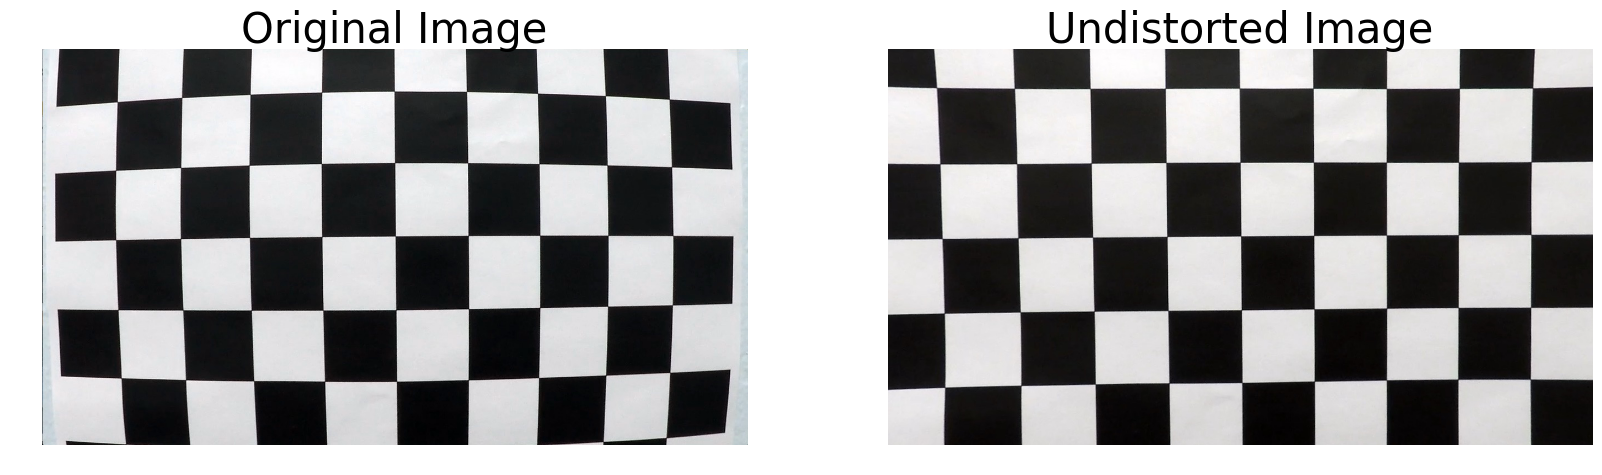

In [3]:
import pickle
%matplotlib inline

# Test undistortion on an image
image = cv2.imread('camera_cal/calibration1.jpg')
image_size = (image.shape[1], image.shape[0])

# Do camera calibration given object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, image_size,None,None)

# Undistort image
dst = cv2.undistort(image, mtx, dist, None, mtx)
cv2.imwrite('camera_cal/calibrated/distorted.jpg',img)
cv2.imwrite('camera_cal/calibrated/undistorted.jpg',dst)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
calibration_pickle = {}
calibration_pickle["mtx"] = mtx
calibration_pickle["dist"] = dist
pickle.dump( calibration_pickle, open("camera_cal/camera_calibration.p", "wb"))
dst = cv2.cvtColor(dst, cv2.COLOR_BGR2RGB)
# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(dst)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')
plt.show()
fig.savefig('output_images/camera_calibration.jpg', dpi=fig.dpi)

## Image Processing Pipeline

### Undistort Image

In [4]:
def undistort(image, calibration):
    """ Correct for camera distortion
    image -- image to undistort
    calibration -- dictionary containing mtx and dist calibration values
    returns -- undistorted image
    """
    mtx = calibration['mtx']
    dist = calibration['dist']
    return cv2.undistort(image, mtx, dist, None, mtx)

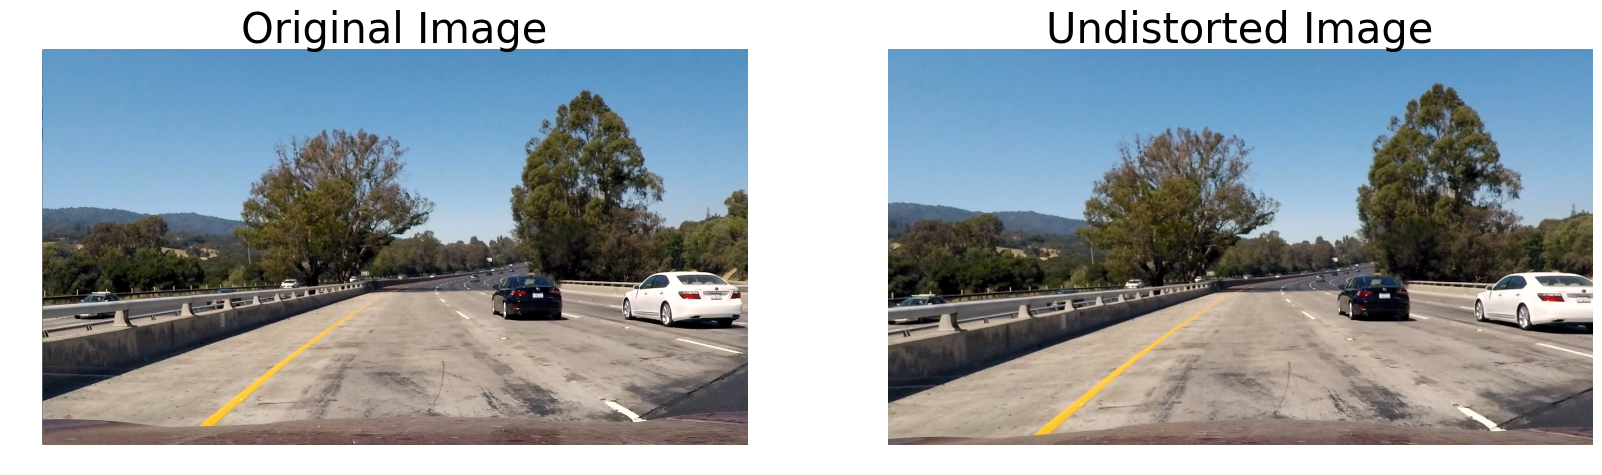

In [5]:
file = 'test_images/test1.jpg'
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
camera_calibration = pickle.load(open('camera_cal/camera_calibration.p', 'rb'))
undistorted_image = undistort(image, camera_calibration)

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(undistorted_image)
ax2.set_title('Undistorted Image', fontsize=30)
ax2.axis('off')
plt.show()
fig.savefig('output_images/undistort.jpg', dpi=fig.dpi)

### Transform to Birds Eye View

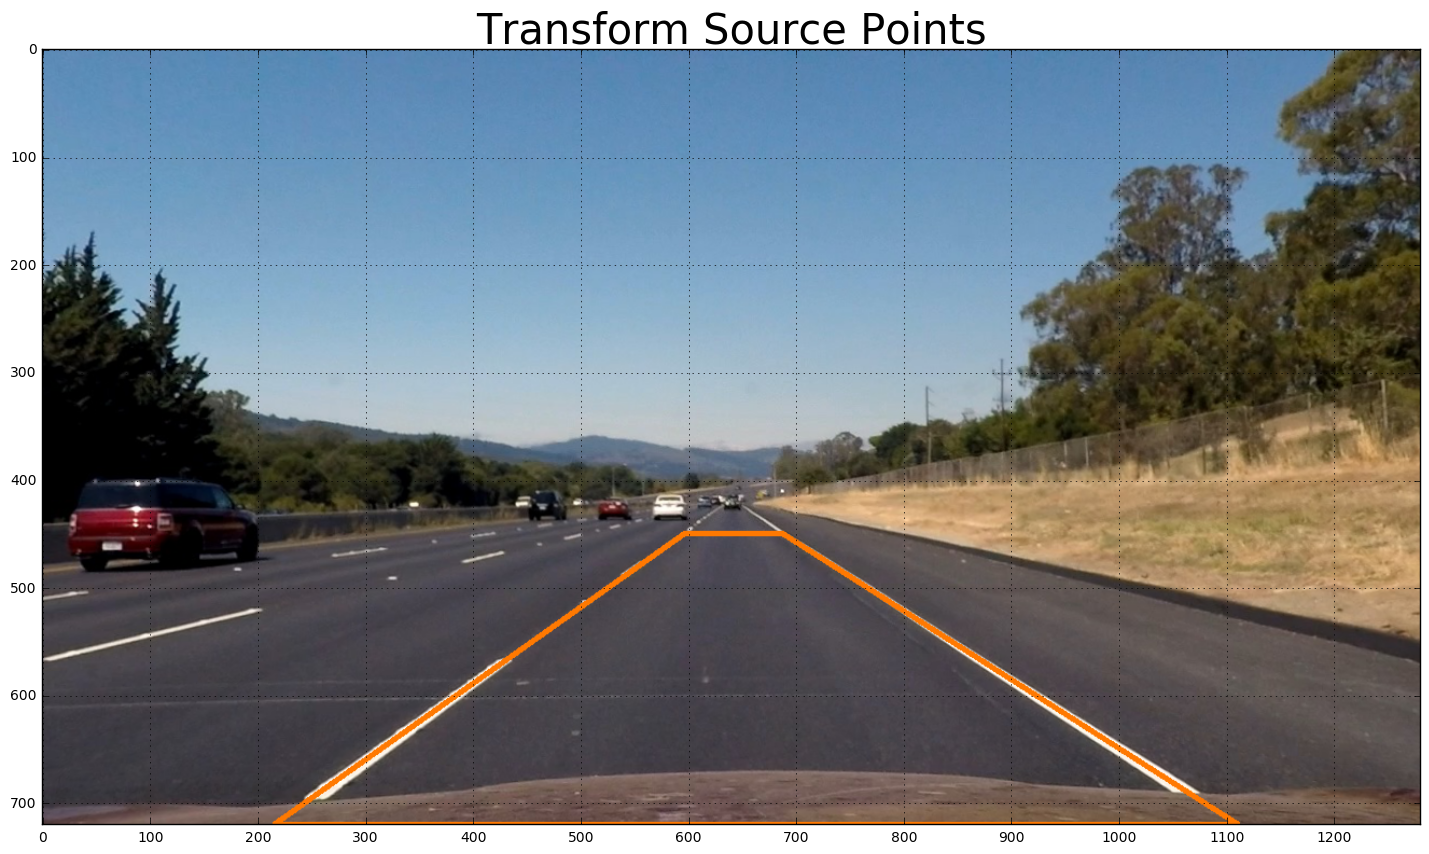

In [6]:
color = {}
color["perspective"] = (255, 121, 1)

# Load image for perspective testing
image = cv2.imread('test_images/straight_lines2.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
image_size = (image.shape[1], image.shape[0])

# Undistort image
undistorted_image = undistort(image, camera_calibration)

# Determine and draw source points for transform
far_lane = 450
src = np.array([[215, image_size[1]],
                [1110, image_size[1]],
                [687, far_lane],
                [596, far_lane]], np.float32)

# left_side = (src[0][0] + src[3][0])/2
# right_side = (src[1][0] + src[2][0])/2

center = image_size[0]/2
width = 700
left_side = center - width/2
right_side = center + width/2


dst = np.array([[left_side, image_size[1]],
                [right_side, image_size[1]],
                [right_side, 0],
                [left_side, 0]], np.float32)

src_draw = src.reshape((-1,1,2)).astype(int)
cv2.polylines(undistorted_image, [src_draw], True,color["perspective"], thickness=3)

fig = plt.figure(figsize=(20,10))
plt.imshow(undistorted_image)
plt.grid(True)
plt.xticks(np.arange(0, 1300, 100.0))
plt.yticks(np.arange(0, 800, 100.0))
plt.title('Transform Source Points', fontsize=30)
plt.show()

Source Points
[[  215.   720.]
 [ 1110.   720.]
 [  687.   450.]
 [  596.   450.]] 

Desitnation Points
[[ 290.  720.]
 [ 990.  720.]
 [ 990.    0.]
 [ 290.    0.]] 

Transform Matrix
[[ -5.60448359e-01  -1.48225247e+00   9.79911930e+02]
 [ -3.44169138e-15  -1.91086202e+00   8.59887910e+02]
 [ -3.03576608e-18  -2.38412953e-03   1.00000000e+00]] 

Inverse Transform Matrix
[[  1.30000000e-01  -7.97416201e-01   5.58300000e+02]
 [  2.22044605e-15  -5.23324022e-01   4.50000000e+02]
 [ -2.16840434e-18  -1.24767225e-03   1.00000000e+00]]


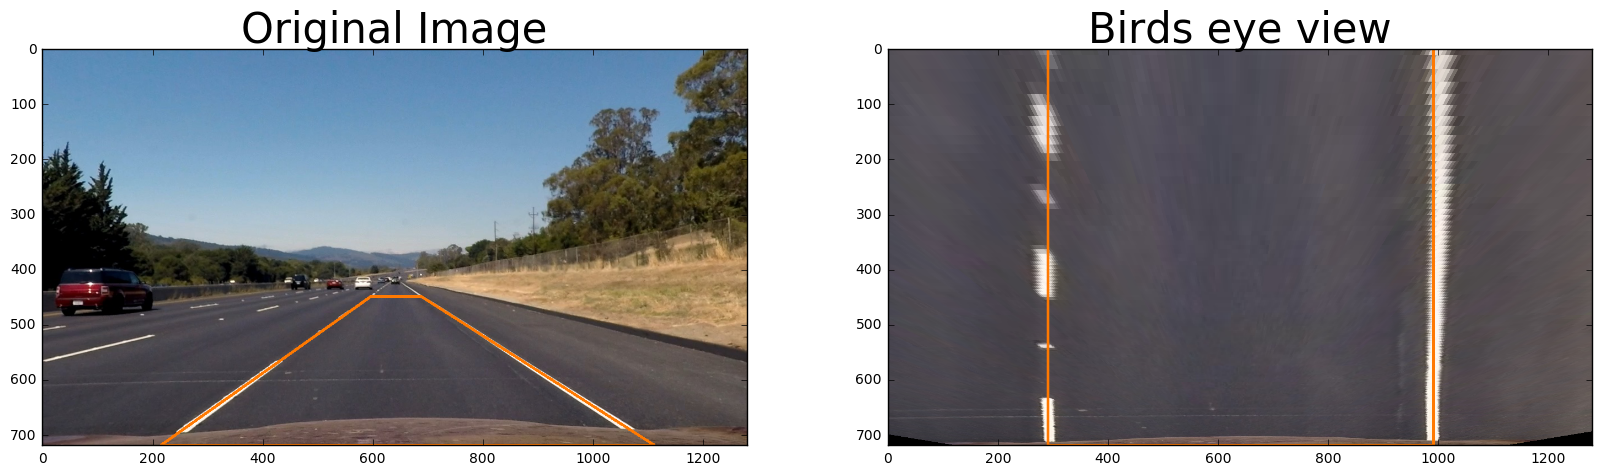

In [8]:
print("Source Points")
print(src, "\n")
print("Desitnation Points")
print(dst, "\n")

# Undistort image
undistorted_image = undistort(image, camera_calibration)

# Transform image
M = cv2.getPerspectiveTransform(src,dst)
M_inv = cv2.getPerspectiveTransform(dst,src)
print("Transform Matrix")
print(M, "\n")
print("Inverse Transform Matrix")
print(M_inv)
warped = cv2.warpPerspective(undistorted_image, M, image_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

# Draw bird's eye view lines
dst_draw = dst.reshape((-1,1,2)).astype(int)
cv2.polylines(warped, [dst_draw], True,color["perspective"], thickness=3)

# Draw driver perspective lines
cv2.polylines(undistorted_image, [src_draw], True, color["perspective"], thickness=3)

# Save the camera calibration result for later use (we won't worry about rvecs / tvecs)
trasform_pickle = {}
trasform_pickle["driver2bird"] = M
trasform_pickle["bird2driver"] = M_inv
pickle.dump(trasform_pickle, open( "transform.p", "wb"))

# Visualize transform
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(undistorted_image)
ax1.set_title('Original Image', fontsize=30)
# ax1.axis('off')
ax2.imshow(warped)
ax2.set_title('Birds eye view', fontsize=30)
# ax2.axis('off')
plt.show()
# fig.savefig('output_images/birds_eye.jpg', dpi=fig.dpi)

In [9]:
perspective = pickle.load(open('transform.p', 'rb'))

def transform(image, M):
    """ Transform to image using the predetermined transform matrix M
    image -- road view image
    M -- transform matrix, use the transform.p file and either driver2bird or bird2driver
    return -- transformed image
    """
    image_size = (image.shape[1], image.shape[0])
    return cv2.warpPerspective(image, M, image_size, flags=cv2.INTER_NEAREST)  # keep same size as input image

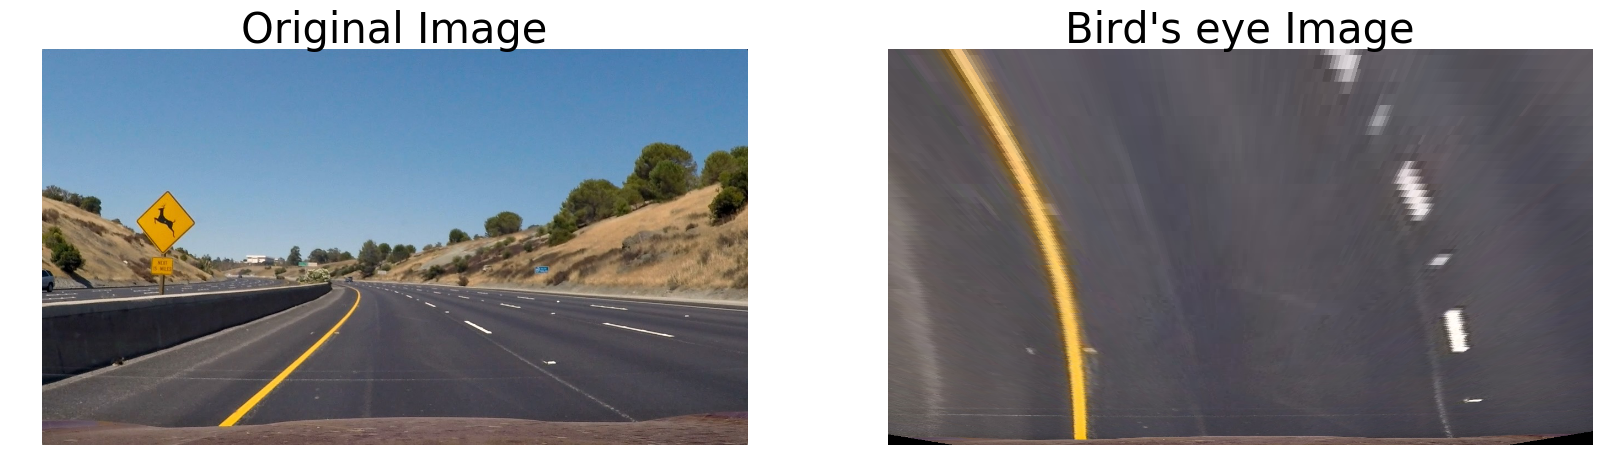

In [10]:
file = 'test_images/test2.jpg'
image = cv2.imread(file)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
transform_matrix = pickle.load(open('transform.p', 'rb'))
birds_eye_image = transform(image, transform_matrix["driver2bird"])

# Visualize undistortion
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image)
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(birds_eye_image)
ax2.set_title('Bird\'s eye Image', fontsize=30)
ax2.axis('off')
plt.show()
fig.savefig('output_images/birds_eye.jpg', dpi=fig.dpi)

### Scrub Image to Binary

In [302]:
def binary_threshold(image, thresh=(0, 255)):
    """Convert the image to binary based on the pixle value falling
    with in the threshold boundary"""
    # Rescale to 8 bit integer
    scaled_image = np.uint8(255*image/np.max(image))
    # Create a copy and apply the threshold
    binary_output = np.zeros_like(scaled_image)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    binary_output[(scaled_image >= thresh[0]) & (scaled_image <= thresh[1])] = 1
    return binary_output

def sobel(image, orient='x', sobel_kernel=3):
    """Gradient in either the x or y direction"""
    if orient == 'x':
        sobel = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:
        sobel = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    return sobel
    
def abs_sobel_thresh(image, orient='x', sobel_kernel=3, thresh=(0, 255)):
    """Absolute value of the gradient in either the x or y direction"""
    # Take gradient in specified direction
    gradient = sobel(image, orient, sobel_kernel)
    # absolute value of gradient
    abs_sobel = np.absolute(gradient)
    return binary_threshold(abs_sobel, thresh)

def mag_thresh(image, sobel_kernel=3, thresh=(0, 255)):
    """Calculate the magnitude of the gradient"""
    sobel_x = sobel(image, 'x', sobel_kernel)
    sobel_y = sobel(image, 'y', sobel_kernel)
    magnitude = np.sqrt(sobel_x**2 + sobel_y**2)
    # Apply threshold
    return binary_threshold(magnitude, thresh)

def dir_threshold(image, sobel_kernel=3, thresh=(0, np.pi/2)):
    """Calculate the direction of the gradient"""
    sobelx = cv2.Sobel(image, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(image, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output  

def find_edges(image):
    image = np.copy(image)
    
    imshape = image.shape
    mask_definition = np.array([[(0/20 *  imshape[1],       imshape[0]),
                                 (9/20 *  imshape[1], 450),
                                 (11/20 * imshape[1], 450),
                                 (20/20 * imshape[1],       imshape[0])]], dtype=np.int32)

    # convert to HLS color space
    hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS).astype(np.float)
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    

    binary_ldir = dir_threshold(l_channel, sobel_kernel=11, thresh=(0.6, 1.4))
    binary_lmag = mag_thresh(l_channel, sobel_kernel=7, thresh=(25, 120))
    binary_sdir = dir_threshold(s_channel, sobel_kernel=11, thresh=(0.6, 1.4))
    binary_smag = mag_thresh(s_channel, sobel_kernel=7, thresh=(25, 120))
    binary_s = binary_threshold(s_channel, thresh=(30, 255))
    combined = np.zeros_like(l_channel)    
    combined[((binary_ldir == 1) & ((binary_lmag == 1))) | \
            ((binary_sdir == 1) & ((binary_smag == 1)))] = 1
  
    return combined

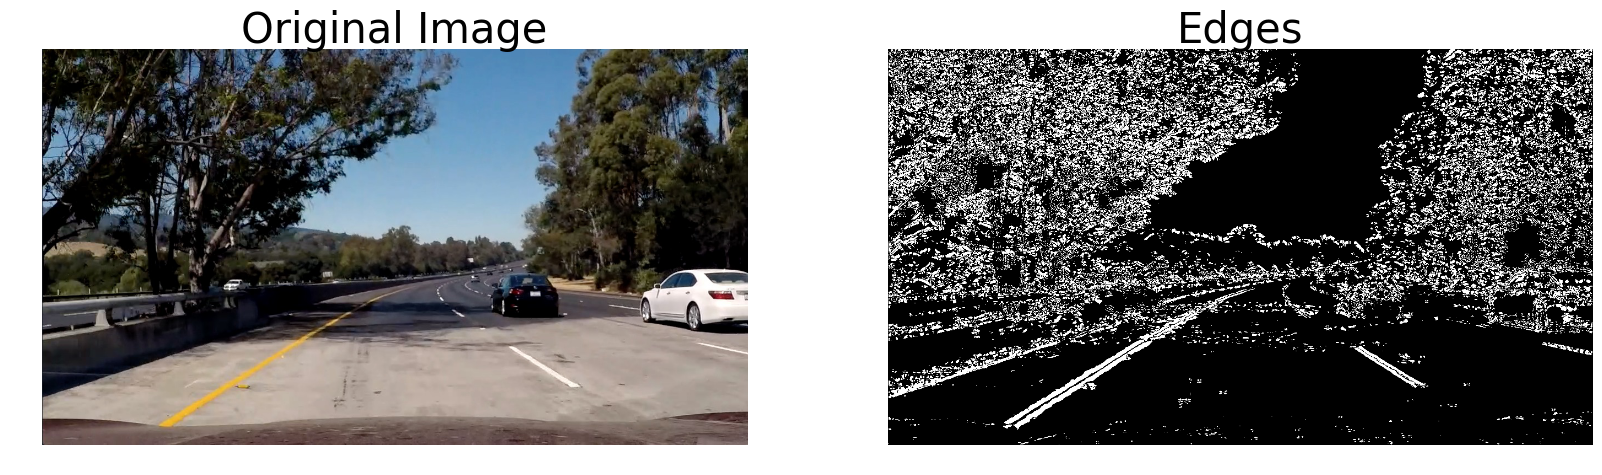

In [308]:
# Load image for testing
image = cv2.imread('test_images/test5.jpg')
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

binary_image = find_edges(image)

hls = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
h_channel = cv2.equalizeHist(hls[:,:,1]).astype(np.float)
l_channel = cv2.equalizeHist(hls[:,:,1]).astype(np.float)
s_channel = cv2.equalizeHist(hls[:,:,2]).astype(np.float)

# Visualize transform
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,10))
ax1.imshow(image, cmap='gray')
ax1.set_title('Original Image', fontsize=30)
ax1.axis('off')
ax2.imshow(binary_image, cmap='gray')
ax2.set_title('Edges', fontsize=30)
ax2.axis('off')
plt.show()
# fig.savefig('output_images/birds_eye.jpg', dpi=fig.dpi)

### Identify Lane Markers and Fit Polynomial

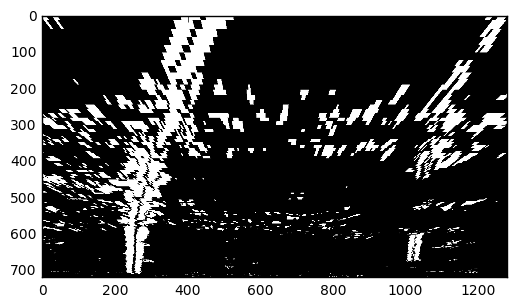

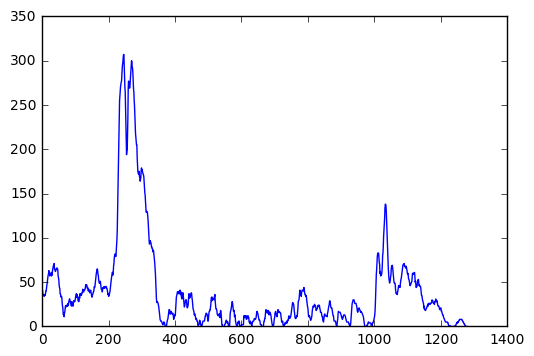

[  5.23670428e-04  -6.27904185e-01   4.42459563e+02]
[  5.16037249e-04  -6.43488707e-01   1.24536793e+03]


In [304]:
# Take a histogram of the bottom half of the image
binary_warped = transform(binary_image, transform_matrix['driver2bird'])
plt.imshow(binary_warped, cmap='gray')
plt.show()
histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
plt.plot(histogram)
plt.show()
# Create an output image to draw on and  visualize the result
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
# Find the peak of the left and right halves of the histogram
# These will be the starting point for the left and right lines
midpoint = np.int(histogram.shape[0]/2)
leftx_base = np.argmax(histogram[:midpoint])
rightx_base = np.argmax(histogram[midpoint:]) + midpoint

# Choose the number of sliding windows
nwindows = 9
# Set height of windows
window_height = np.int(binary_warped.shape[0]/nwindows)
# Identify the x and y positions of all nonzero pixels in the image
nonzero = binary_warped.nonzero()
nonzeroy = np.array(nonzero[0])
nonzerox = np.array(nonzero[1])
# Current positions to be updated for each window
leftx_current = leftx_base
rightx_current = rightx_base
# Set the width of the windows +/- margin
margin = 100
# Set minimum number of pixels found to recenter window
minpix = 50
# Create empty lists to receive left and right lane pixel indices
left_lane_inds = []
right_lane_inds = []

# Step through the windows one by one
for window in range(nwindows):
    # Identify window boundaries in x and y (and right and left)
    win_y_low = binary_warped.shape[0] - (window+1)*window_height
    win_y_high = binary_warped.shape[0] - window*window_height
    win_xleft_low = leftx_current - margin
    win_xleft_high = leftx_current + margin
    win_xright_low = rightx_current - margin
    win_xright_high = rightx_current + margin
    # Draw the windows on the visualization image
    cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high),(0,255,0), 2) 
    cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high),(0,255,0), 2) 
    # Identify the nonzero pixels in x and y within the window
    good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
    good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
    # Append these indices to the lists
    left_lane_inds.append(good_left_inds)
    right_lane_inds.append(good_right_inds)
    # If you found > minpix pixels, recenter next window on their mean position
    if len(good_left_inds) > minpix:
        leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
    if len(good_right_inds) > minpix:        
        rightx_current = np.int(np.mean(nonzerox[good_right_inds]))

# Concatenate the arrays of indices
left_lane_inds = np.concatenate(left_lane_inds)
right_lane_inds = np.concatenate(right_lane_inds)

# Extract left and right line pixel positions
leftx = nonzerox[left_lane_inds]
lefty = nonzeroy[left_lane_inds] 
rightx = nonzerox[right_lane_inds]
righty = nonzeroy[right_lane_inds] 

# Fit a second order polynomial to each
left_fit = np.polyfit(lefty, leftx, 2)
right_fit = np.polyfit(righty, rightx, 2)

print(left_fit)
print(right_fit)

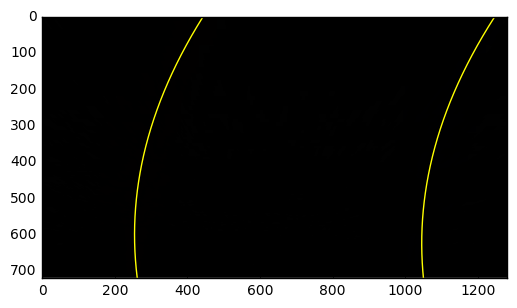

In [310]:
# Generate x and y values for plotting
ploty = np.linspace(0, binary_warped.shape[0]-1, binary_warped.shape[0] )
left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
plt.imshow(out_img)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

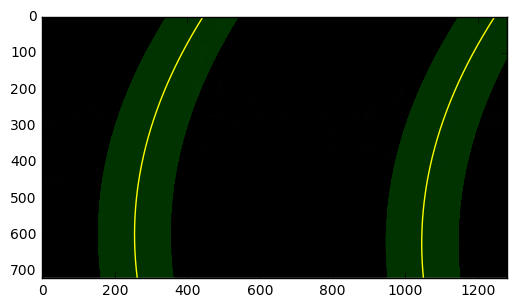

In [306]:
# Create an image to draw on and an image to show the selection window
out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
window_img = np.zeros_like(out_img)
# Color in left and right line pixels
out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]

# Generate a polygon to illustrate the search window area
# And recast the x and y points into usable format for cv2.fillPoly()
left_line_window1 = np.array([np.transpose(np.vstack([left_fitx-margin, ploty]))])
left_line_window2 = np.array([np.flipud(np.transpose(np.vstack([left_fitx+margin, ploty])))])
left_line_pts = np.hstack((left_line_window1, left_line_window2))
right_line_window1 = np.array([np.transpose(np.vstack([right_fitx-margin, ploty]))])
right_line_window2 = np.array([np.flipud(np.transpose(np.vstack([right_fitx+margin, ploty])))])
right_line_pts = np.hstack((right_line_window1, right_line_window2))

# Draw the lane onto the warped blank image
cv2.fillPoly(window_img, np.int_([left_line_pts]), (0,255, 0))
cv2.fillPoly(window_img, np.int_([right_line_pts]), (0,255, 0))
result = cv2.addWeighted(out_img, 1, window_img, 0.3, 0)
plt.imshow(result)
plt.plot(left_fitx, ploty, color='yellow')
plt.plot(right_fitx, ploty, color='yellow')
plt.xlim(0, 1280)
plt.ylim(720, 0)
plt.show()

### Calculate Radius of Curvature of the Lane and Position of Vehicle

In [307]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension
y_eval = 720
# Fit new polynomials to x,y in world space
left_fit_cr = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
right_fit_cr = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
# Calculate the new radii of curvature
left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
# Now our radius of curvature is in meters
print(left_curverad, 'm', right_curverad, 'm')
left_pos = left_fit[0]*y_eval**2 + left_fit[1]*y_eval + left_fit[2]
right_pos = right_fit[0]*y_eval**2 + right_fit[1]*y_eval + right_fit[2]

lane_center = (left_pos + right_pos)/2*xm_per_pix
vehicle_offset = lane_center - 1280*xm_per_pix/2
print(vehicle_offset)

313.727566448 m 318.322095422 m
0.0830096905963


### Project Lane on Original Image

## Video Processing